In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from my_utils import *

from laplace2D import *

import copy

In [2]:
my_grid = grid(-0.7e-3,0.7e-3,20e-6,-0.1e-3,0.5e-3,20e-6)

c1 = conductor(-1e-3,1e-3,-0.5e-3,0,V=0.)
c2 = conductor(-100e-6,100e-6,140e-6,160e-6,V=1.)
d1 = dielectric(-1e-3,1e-3,-20e-6,150e-6,eps_r=3.5)
conductor_list = [c1,c2]
dielectric_list = [d1]

In [3]:
V = field(grid=my_grid)
fixed_mask, start_potential = conductors_to_mask(my_grid,conductor_list)
potential = copy.deepcopy(start_potential)
epsilon = gen_dielectric_field(my_grid,dielectric_list)

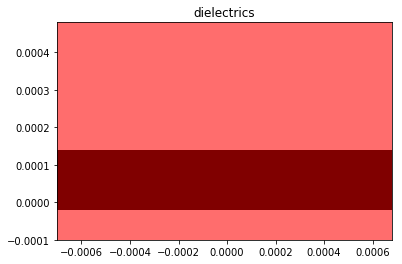

In [4]:

scale= np.max(epsilon.matrix)

plt.pcolormesh(my_grid.X,my_grid.Y,epsilon.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("dielectrics")
plt.show()

In [5]:
for i in range(10000):
    relax_2D_dielectric(potential,fixed_mask,epsilon)

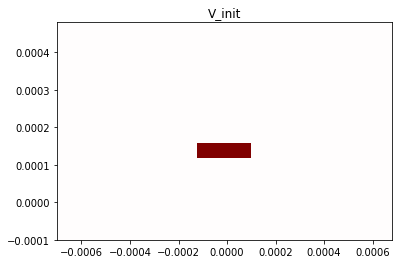

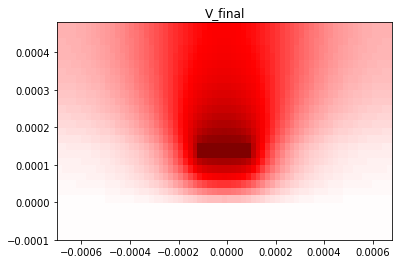

In [6]:
#small_figure()

scale= 1

plt.pcolormesh(my_grid.X,my_grid.Y,start_potential.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("V_init")
plt.show()

plt.pcolormesh(my_grid.X,my_grid.Y,potential.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("V_final")
plt.show()

In [7]:
E = E_from_V(potential)

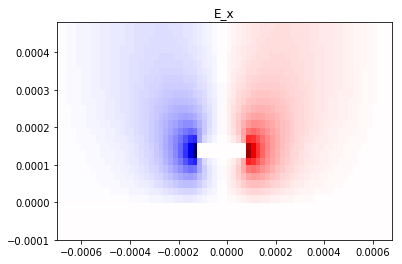

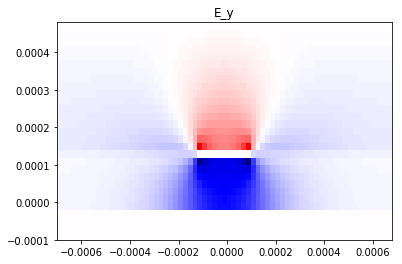

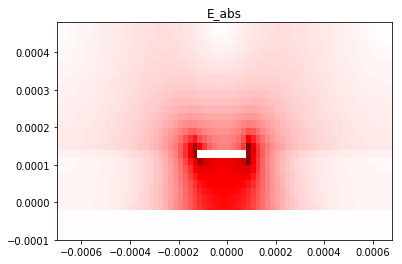

In [8]:
e_abs = np.sqrt(E.matrix[:,:,0]**2 + E.matrix[:,:,1]**2)

scale = np.max(e_abs)


plt.pcolormesh(my_grid.X,my_grid.Y,E.matrix[:,:,0],cmap="seismic")
plt.clim(-scale,scale)
plt.title("E_x")
plt.show()

plt.pcolormesh(my_grid.X,my_grid.Y,E.matrix[:,:,1],cmap="seismic")
plt.clim(-scale,scale)
plt.title("E_y")
plt.show()

plt.pcolormesh(my_grid.X,my_grid.Y,e_abs, cmap='seismic')
plt.clim(-scale,scale)
plt.title("E_abs")
plt.show()

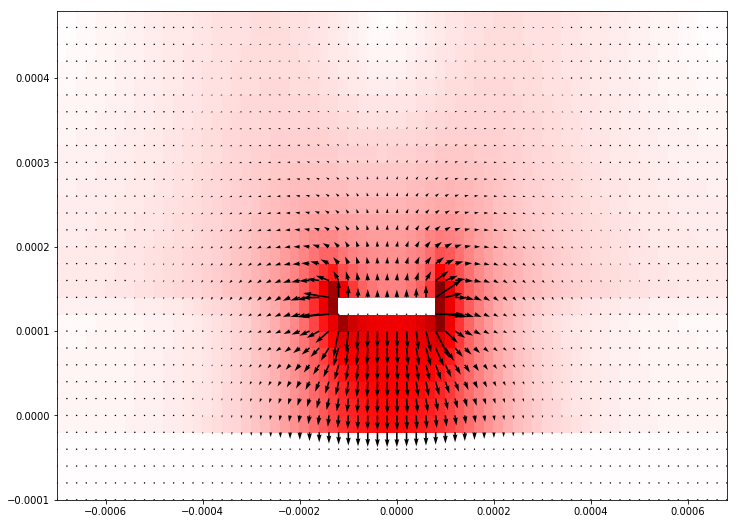

In [9]:
big_figure()

scale = np.max(e_abs)
plt.pcolormesh(my_grid.X,my_grid.Y,e_abs,cmap="seismic")
plt.clim(-scale,scale)
plt.quiver(my_grid.X,my_grid.Y,E.matrix[:,:,0],E.matrix[:,:,1], scale=3e5)

#plt.xlim(-0.8,0.8)
#plt.ylim(-0.3,0.6)
plt.show()

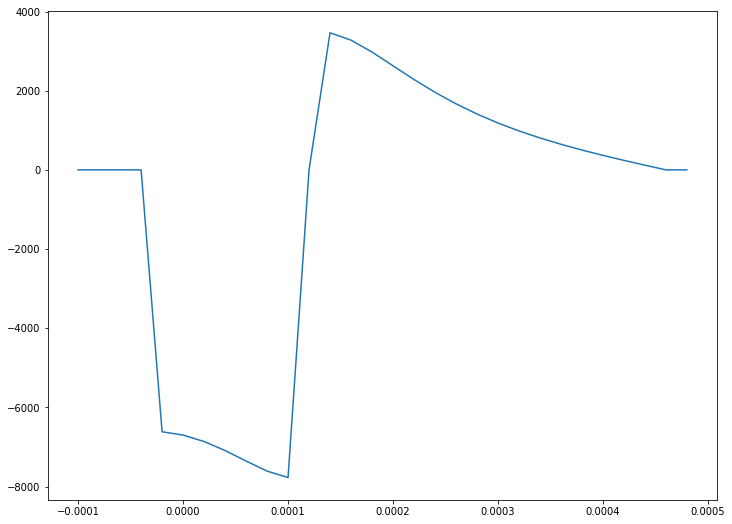

In [10]:
middle_i , middle_j = my_grid.pos_to_index(0,0)

plt.plot(my_grid.y_edges,E.matrix[:,middle_j,1])

In [11]:
rho = rho_from_V(potential,epsilon)

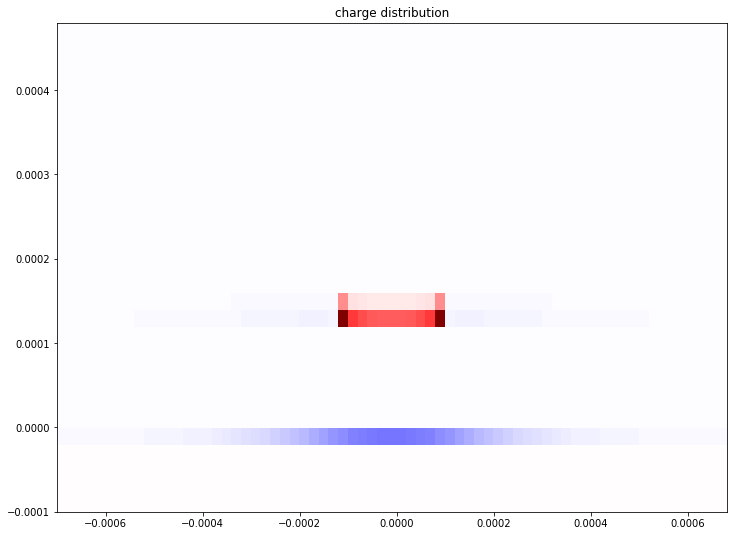

In [12]:
scale = np.max(np.abs(rho.matrix))

plt.pcolormesh(my_grid.X,my_grid.Y,rho.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge distribution")
plt.show()

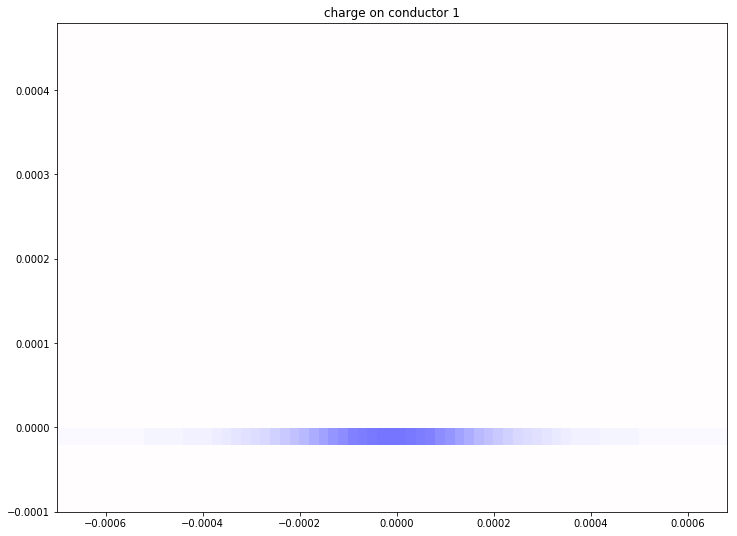

-9.044868975494864e-11

In [13]:
#scale = 8e-10

area_element = my_grid.x_step * my_grid.y_step

c1_mask, dummy = conductors_to_mask(my_grid,[c1])

plt.pcolormesh(my_grid.X,my_grid.Y,rho.matrix * c1_mask.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge on conductor 1")
plt.show()

np.sum(rho.matrix * c1_mask.matrix) * area_element 

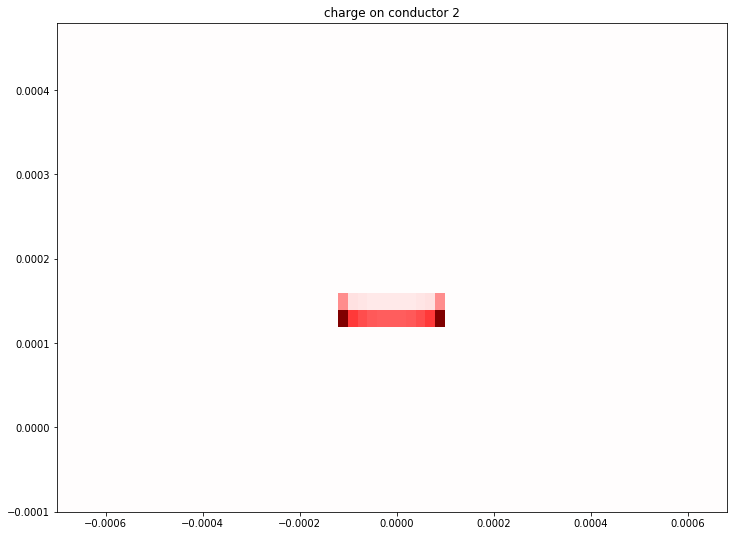

9.044869011178948e-11

In [14]:
#scale = 8e-10

c2_mask, dummy = conductors_to_mask(my_grid,[c2])

plt.pcolormesh(my_grid.X,my_grid.Y,rho.matrix * c2_mask.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge on conductor 2")
plt.show()

np.sum(rho.matrix * c2_mask.matrix) * area_element

In [15]:
#B1 = B_of_conductor(c1,rho,fixed_mask)
#B2 = B_of_conductor(c2,rho,fixed_mask)

In [16]:
Bk = my_grid.B_kernel()

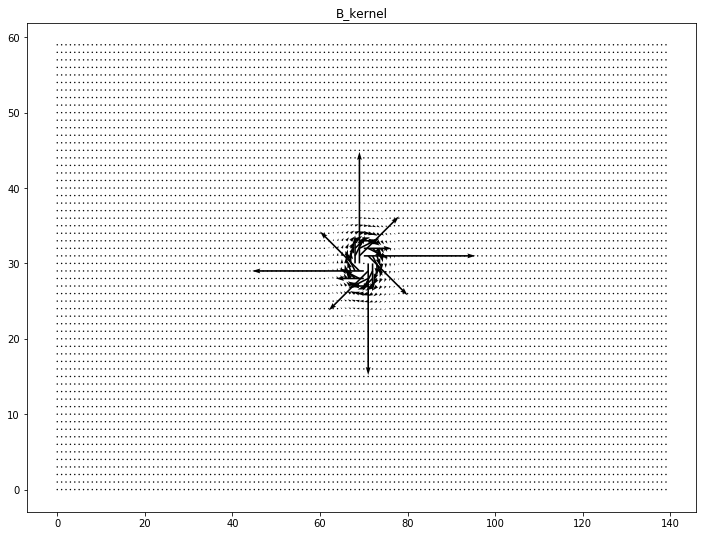

In [17]:
#plt.pcolormesh(my_grid.X,my_grid.Y,Bk.abs_matrix(), cmap=cmap)
scale = 100
#plt.clim(0,scale)
plt.quiver(Bk[:,:,0],Bk[:,:,1], scale=3000)
plt.title("B_kernel")
plt.show()

In [18]:
rho2 = rho.matrix * c2_mask.matrix

In [19]:
def B_from_J(J,conductor_mask=None):
    B_kernel = J.grid.B_kernel()
    B = field(J.grid,nd=2)
    
    if(conductor_mask is None):
        B.matrix[:,:,0] = Bconv(J.matrix,B_kernel[:,:,0])
        B.matrix[:,:,1] = Bconv(J.matrix,B_kernel[:,:,1])
    else:
        mask = 1-conductor_mask.matrix
        B.matrix[:,:,0] = Bconv(J.matrix,B_kernel[:,:,0])*mask
        B.matrix[:,:,1] = Bconv(J.matrix,B_kernel[:,:,1])*mask
    return B

In [20]:
def J_of_conductor(conductor,rho):
    J = field(rho.grid)
    conductor_mask, dummy = conductors_to_mask(my_grid,[conductor])
    I = rho.matrix * conductor_mask.matrix
    signI = np.sign(I)
    I *= signI/np.sum(I)
    J.matrix = I
    return J

In [21]:
J1 = J_of_conductor(c1,rho)
J2 = J_of_conductor(c2,rho)

J = field(my_grid)
J.matrix = -(J1.matrix + J2.matrix)

Bfft = B_from_J(J,fixed_mask)

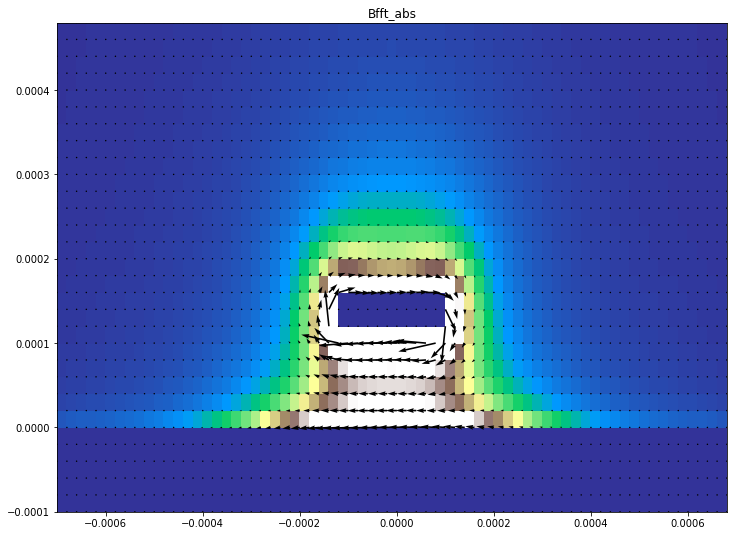

In [22]:
b_abs = Bfft.abs_matrix()

scale = np.max(b_abs)

cmap="seismic"
cmap="terrain"

scale = 30


plt.pcolormesh(my_grid.X,my_grid.Y,b_abs, cmap=cmap)
plt.clim(0,scale)
plt.quiver(my_grid.X,my_grid.Y,Bfft.matrix[:,:,0],Bfft.matrix[:,:,1], scale=2000)
plt.title("Bfft_abs")
plt.show()

#plt.pcolormesh(my_grid.X,my_grid.Y,b_abs, cmap=cmap)
#plt.clim(0,scale)
#plt.quiver(my_grid.X,my_grid.Y,B.matrix[:,:,0],B.matrix[:,:,1], scale=2000)
#plt.title("B_abs")
#plt.show()